# 호텔 예약 취소율 개선을 위한 EDA
hotel_data_modified.csv 데이터 분석을 통해
City Hotel과 Resort Hotel의 예약 취소와 관련된 요소들을 파악해보고,

어떻게 하면 예약 취소율을 개선할 수 있을지 아이디어를 얻어보겠습니다.



In [ ]:
import pandas as pd

hotel = pd.read_csv("sample_data/hotel_data_modified.csv")
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,C,C,3,NaN,NaN,0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,C,C,4,NaN,NaN,0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,A,C,0,NaN,NaN,0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,A,0,304.0,NaN,0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,A,0,240.0,NaN,0,0,1,Check-Out,2015-07-03


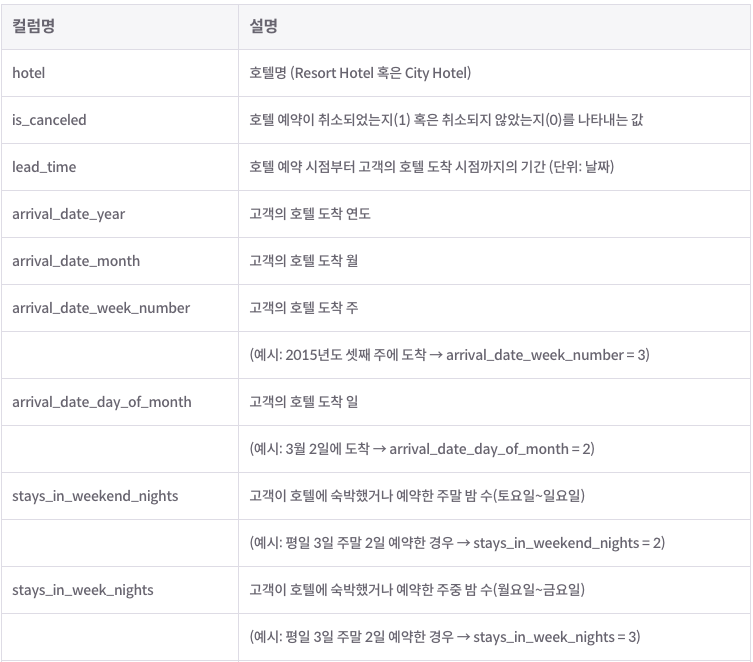

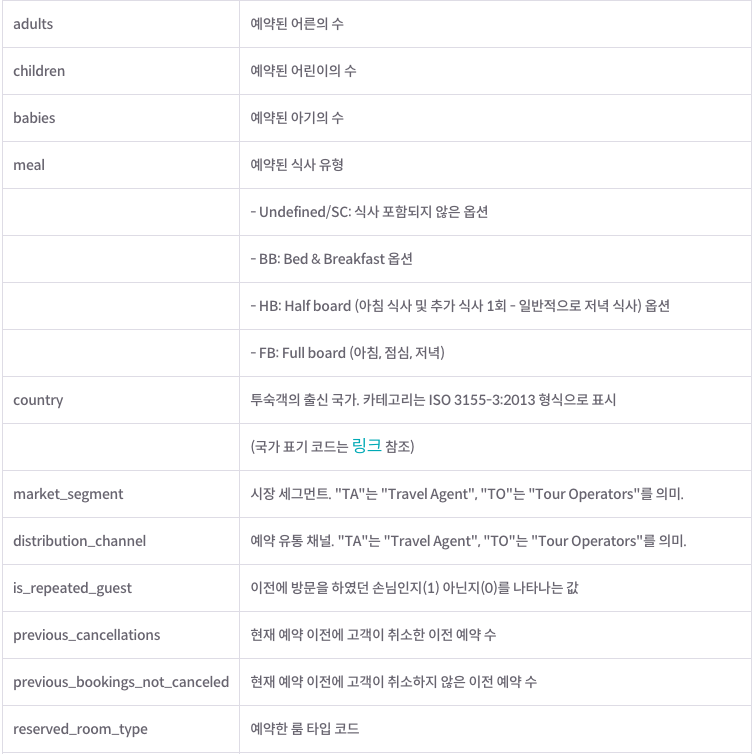

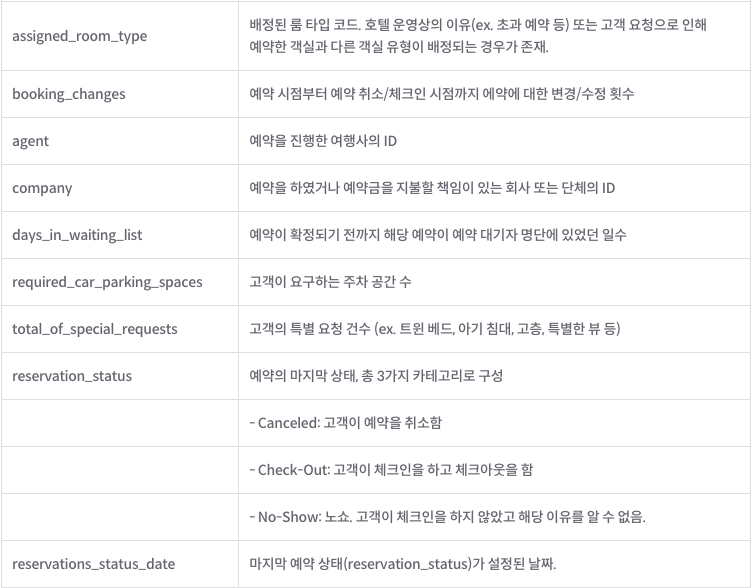

## 1. 데이터 가공
먼저 결측값 확인 후 처리하겠습니다.

In [ ]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84348 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   hotel                           84348 non-null  object  
 1   is_canceled                     84348 non-null  int64   
 2   lead_time                       84348 non-null  int64   
 3   arrival_date_year               84348 non-null  int64   
 4   arrival_date_month              84348 non-null  object  
 5   arrival_date_week_number        84348 non-null  int64   
 6   arrival_date_day_of_month       84348 non-null  int64   
 7   stays_in_weekend_nights         84348 non-null  int64   
 8   stays_in_week_nights            84348 non-null  int64   
 9   adults                          84348 non-null  int64   
 10  children                        84348 non-null  float64 
 11  babies                          84348 non-null  int64   
 12  meal                  

In [ ]:
hotel.isna().sum()  # 결측치 확인. children(4), country(488), agent(16340), company(112593) 에 결측치 존재

,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [ ]:
hotel["children"].value_counts()

# children 컬럼 대부분 값이 0이기 때문에 결측치(4개)도 0으로 처리
hotel["children"] = hotel["children"].fillna(0)

In [ ]:
hotel["country"].value_counts()

# country 컬럼은 결측치를 대체할 값도 마땅치 않고, 유의미하게 쓰이지 않을 것 같으므로 컬럼 삭제
hotel = hotel.drop("country", axis=1)

In [ ]:
import numpy as np

print(hotel["agent"].isnull().sum() / len(hotel["agent"]) * 100)

# agent 컬럼은 삭제하기엔 비중이 높고, 대체할 값은 명확하지 않으며 object이므로 "Unknown"으로 변경
hotel["agent"] = hotel["agent"].fillna("Unknown")
hotel["agent"].isna().sum()

0.0


np.int64(0)

In [ ]:
print(hotel["company"].isnull().sum() / len(hotel["company"]) * 100)

# company 컬럼은 결측치가 대부분이므로, 아예 컬럼을 삭제하겠습니다.
hotel = hotel.drop("company", axis=1)


94.30689337465449


이제 중복값 제거하겠습니다.

In [ ]:
hotel = hotel.drop_duplicates()

# 제거 확인
hotel.duplicated().sum()

np.int64(0)

## 2. Columns로 가설 세우기
자 이제 데이터가 깔끔해졌습니다. 그런데 컬럼의 종류가 상당히 많아 무엇을 분석할지 정해야겠군요..

컬럼들을 읽으며 취소율과 관련이 있을법한 6가지 가설을 추려봤습니다.

1. *직접 예약했을 경우 대리인을 통해 예약했을 때보다 취소율이 낮을 것이다.*
2. *"children", "babies" 가 있으면 변동성이 크므로 취소율이 비교적 높을 것이다.*
3. *여행기간이 주말 or 평일인지에 따라 취소율 차이가 있을 수 있겠다.*
4. *예약변경 횟수가 많을수록 취소율은 낮을 것이다.*
5. *할당된 객실 유형(A~C타입)에 따라 취소율이 과연 다를까?*
6. *고객 요청과 다른 타입의 객실로 배정된 경우, 취소율이 높을 것이다.*

## 3. 가설 검증
이제 위 6가지 가설을 하나하나 검증해볼게요!

### *가설 1. 직접 예약했을 경우 대리인을 통해 예약했을 때보다 취소율이 낮을 것이다 ?*

관련 컬럼 : "market_segment" , "distribution_channel"
- TA / TO 등 : 대리인 통해 예약
- Direct : 직접 예약

#### 가설 1-1. market_segment 취소율
"market_segment" 컬럼 값은 종류가 많네요. 상위 5개 값들의 취소율만 살펴보겠습니다.

In [ ]:
hotel["market_segment"].value_counts()

,count
market_segment,
Online TA,56477
Offline TA/TO,24219
Groups,19811
Direct,12606
Corporate,5295
Complementary,743
Aviation,237
Undefined,2


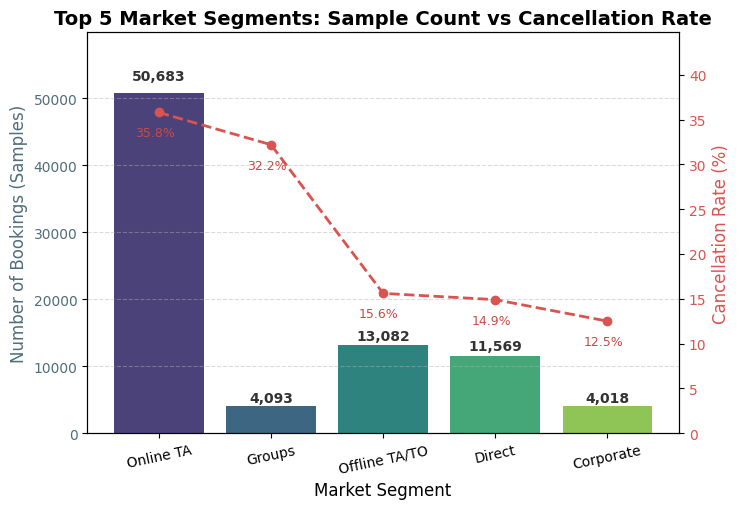

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

top5_segments = hotel["market_segment"].value_counts().head(5).index
top5_data = hotel[hotel["market_segment"].isin(top5_segments)]
market_stats = (
    top5_data.groupby("market_segment")["is_canceled"]
    .agg(["mean", "size"]).reset_index()
)
market_stats.rename(columns={"mean":"cancel_rate","size":"count"}, inplace=True)
market_stats["cancel_rate"] = (market_stats["cancel_rate"]*100).round(1)

# 정렬(원하는 기준으로) - 예: 취소율 내림차순
market_stats = market_stats.sort_values("cancel_rate", ascending=False)
order = market_stats["market_segment"].tolist()

# ---- 그림 ----
fig, ax1 = plt.subplots(figsize=(7.5,5.2))

# 1) 막대: 샘플 수
sns.barplot(
    data=market_stats, x="market_segment", y="count",
    order=order, palette="viridis", hue="market_segment", legend=False, ax=ax1
)

ax1.set_xlabel("Market Segment", fontsize=12)
ax1.set_ylabel("Number of Bookings (Samples)", color="#4f6d7a", fontsize=12)
ax1.tick_params(axis='y', labelcolor="#4f6d7a")

# 여백 주기(막대 위로 라벨 겹침 방지)
ymax = market_stats["count"].max()
ax1.set_ylim(0, ymax * 1.18)   # 막대축 headroom

# 2) 라인: 취소율 (오른쪽 축)
ax2 = ax1.twinx()
xpos = np.arange(len(order))
ax2.plot(
    xpos, market_stats["cancel_rate"].values,
    linestyle="--", marker="o", linewidth=2,
    color="#d9534f", zorder=3
)
ax2.set_ylabel("Cancellation Rate (%)", color="#d9534f", fontsize=12)
ax2.tick_params(axis='y', labelcolor="#d9534f")
ax2.set_ylim(0, market_stats["cancel_rate"].max() * 1.25)  # 퍼센트축 headroom

# 3) 막대 라벨
for p in ax1.patches:
    h = p.get_height()
    x = p.get_x() + p.get_width() / 2

    # 막대 높이에 따라 자동으로 위쪽 여백 비율 조정
    offset = h * 0.03 if h > 0 else 0  # 막대가 클수록 여백도 커짐

    ax1.text(
        x,
        h + offset,                   # 막대 꼭대기에서 비율만큼 위로 띄움
        f"{int(h):,}",
        ha="center",
        va="bottom",
        fontsize=10,
        color="#333333",
        fontweight="bold"
    )

# 4) 취소율 라벨: 점에서 살짝 위로 (픽셀 오프셋 사용)
for xi, y in zip(xpos, market_stats["cancel_rate"].values):
    ax2.annotate(
        f"{y:.1f}%", (xi, y),
        xytext=(-3, -10), textcoords="offset points",  # ← 겹침 방지 핵심
        ha="center", va="top", color="#c64b46", fontsize=9
    )

# 5) 기타 꾸미기
ax1.tick_params(axis="x", rotation=12)
ax1.grid(axis="y", linestyle="--", alpha=0.45)
plt.title("Top 5 Market Segments: Sample Count vs Cancellation Rate", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


와우... 직접 예약한 사람들(Direct)의 취소율이 낮은지만 확인하려고 했는데,

Groups로 예약한 사람들의 취소율이 높다는 것까지 파악이 되었네요!

더불어 Corporate의 취소율이 낮다는 사실도 확인했습니다.

이제 "distribution_channel" 컬럼 분석 결과도 동일한지 확인해볼게요.

#### 가설 1-2. distribution_channel 취소율
distribution_channel 컬럼은 상위 3개의 결과값을 비교해보는게 좋겠군요.

In [ ]:
hotel["distribution_channel"].value_counts()

,count
distribution_channel,
TA/TO,97870
Direct,14645
Corporate,6677
GDS,193
Undefined,5


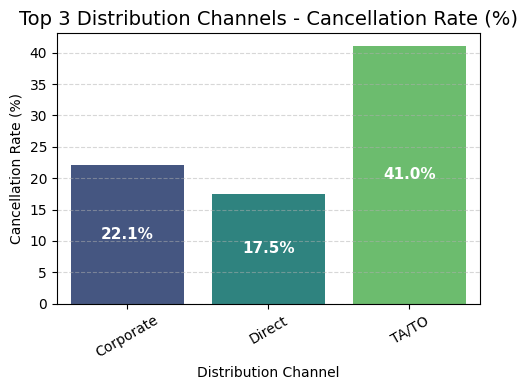

In [ ]:
# 1️⃣ 상위 3개 distribution_channel 추출
top3_segments = hotel["distribution_channel"].value_counts().head(3).index

# 2️⃣ 상위 3개만 필터링
top3_data = hotel[hotel["distribution_channel"].isin(top3_segments)]

# 3️⃣ 각 segment별 취소율(%) 계산
distribution_cancel_rate = (
    top3_data.groupby("distribution_channel")["is_canceled"]
    .mean() * 100
).round(2).reset_index()

# 4️⃣ 막대그래프 시각화 (palette 경고 제거: hue 지정 + legend=False)
plt.figure(figsize=(5,4))
ax = sns.barplot(
    data=distribution_cancel_rate,
    x="distribution_channel",
    y="is_canceled",
    hue="distribution_channel",
    palette="viridis",
    legend=False
)

# 5️⃣ 각 막대 중앙에 수치 표시
for patch, (_, row) in zip(ax.patches, distribution_cancel_rate.iterrows()):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    ax.text(
        x, y / 2,
        f"{row['is_canceled']:.1f}%",
        ha="center", va="center",
        color="white", fontsize=11, fontweight="bold"
    )

# 6️⃣ 그래프 꾸미기
plt.title("Top 3 Distribution Channels - Cancellation Rate (%)", fontsize=14)
plt.xlabel("Distribution Channel")
plt.ylabel("Cancellation Rate (%)")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


=> "market_segment" , "distribution_channel" 모두

Direct (직접 예약한 사람들) -> Corporate 순서로 취소율이 낮은 반면,

TA/TO(대리인을 통해 예약한 사람들)의 취소율은 확실히 높습니다.

특히나 market_segment에서 Groups로 예약한 사람들의 취소율이 높은 것을 통해

단체 예약보다는 개인 예약이 취소율이 적다는 것도 파악할 수 있겠네요.

*   **개인/협업** 예약 < **단체** 예약
*   **직접** 예약 < **대리인** 예약



### *가설 2. 아이들이 있으면 변동성이 크므로 취소율이 비교적 높을 것이다 ?*

관련 컬럼 : "children", "babies"

먼저 "children", "babies" 컬럼의 데이터를 살펴볼게요.

In [ ]:
hotel.value_counts("children")

,count
children,
0.0,110800
1.0,4861
2.0,3652
3.0,76
10.0,1


In [ ]:
hotel.value_counts("babies")

,count
babies,
0,118473
1,900
2,15
9,1
10,1


"children", "babies" 의 값은 0이 가장 많군요.

"children", "babies" 모두 0인 그룹과, 둘 중 하나라도 1 이상인 그룹으로 나눈 후, 취소율을 비교해보겠습니다.


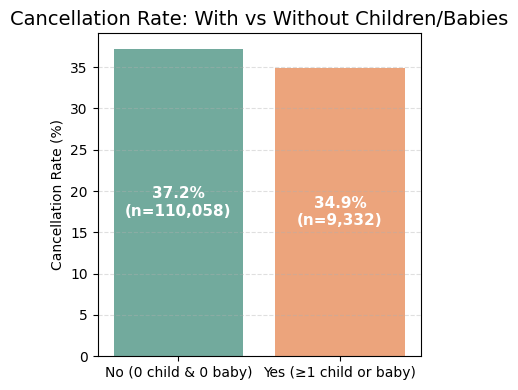

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ 그룹 구분 컬럼 생성
hotel["has_child_or_baby"] = hotel.apply(
    lambda row: "No (0 child & 0 baby)" if (row["children"] == 0 and row["babies"] == 0)
    else "Yes (≥1 child or baby)",
    axis=1
)

# 2️⃣ 각 그룹별 취소율(%)과 샘플 수 계산
cancel_summary = (
    hotel.groupby("has_child_or_baby")["is_canceled"]
    .agg(Count="count", CancelRate="mean")
    .assign(**{"Cancellation Rate (%)": lambda df: (df["CancelRate"] * 100).round(2)})
    .drop(columns="CancelRate")
    .reset_index()
)
cancel_summary.columns = ["Group", "Count", "Cancellation Rate (%)"]

# 3️⃣ 막대그래프 시각화 (FutureWarning 방지)
plt.figure(figsize=(4,4))
ax = sns.barplot(
    data=cancel_summary,
    x="Group",
    y="Cancellation Rate (%)",
    hue="Group",
    palette=["#69b3a2", "#ff9f69"],
    legend=False
)

# 4️⃣ 각 막대 중앙에 “취소율 + 샘플 수” 표시
for patch, (_, row) in zip(ax.patches, cancel_summary.iterrows()):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height() / 2
    ax.text(
        x, y,
        f"{row['Cancellation Rate (%)']:.1f}%\n(n={int(row['Count']):,})",
        ha="center", va="center",
        color="white", fontsize=11, fontweight="bold"
    )

# 5️⃣ 그래프 꾸미기
plt.title("Cancellation Rate: With vs Without Children/Babies", fontsize=14)
plt.xlabel("")
plt.ylabel("Cancellation Rate (%)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


호오 의외의 결과가 나왔군요!

취소율이 큰 차이는 아니지만, 아이가 없는 그룹이 오히려 취소율이 높은 것을 볼 수가 있습니다.

(아이들과 함께 가족여행을 올 때는 오히려 마음 먹고(?) 오는 것이라 취소율이 적은 것일 수도 있겠군요..)

또한 아이가 없는 그룹(No)의 데이터 양이 훨씬 많기 때문에, 이는 비교적 신뢰할 수 있는 데이터이겠네요.
*   **개인/협업** 예약 << **단체** 예약
*   **직접** 예약 << **대리인** 예약
* **아이 有** < **아이 無**

### *가설 3. 여행기간이 주말 or 평일인지에 따라 취소율 차이가 있을 수 있겠다 ?*

관련 컬럼 : "stays_in_weekend_nights" , "stays_in_week_nights"

아래 4개의 그룹으로 나누어 취소율을 비교하겠습니다.

- 주중/주말 밤 모두 묵지 않는 0박 그룹
- 주말 밤에만 묵는 그룹
- 주중 밤에만 묵는 그룹
- 주중/주말 밤 모두 묵는 그룹

In [ ]:
hotel.value_counts("stays_in_weekend_nights")

,count
stays_in_weekend_nights,
0,51998
2,33308
1,30626
4,1855
3,1259
6,153
5,79
8,60
7,19


In [ ]:
hotel.value_counts("stays_in_week_nights")

,count
stays_in_week_nights,
2,33684
1,30310
3,22258
5,11077
4,9563
0,7645
6,1499
10,1036
7,1029


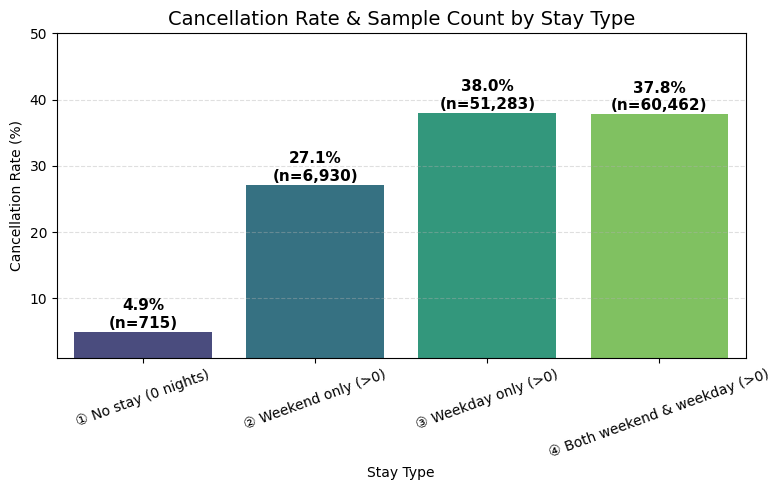

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) 4그룹 만들기
def stay_group(row):
    weekend = row["stays_in_weekend_nights"]
    week = row["stays_in_week_nights"]
    if weekend == 0 and week == 0:
        return "① No stay (0 nights)"
    elif week == 0 and weekend > 0:
        return "② Weekend only (>0)"
    elif weekend == 0 and week > 0:
        return "③ Weekday only (>0)"
    else:
        return "④ Both weekend & weekday (>0)"

hotel["stay_group"] = hotel.apply(stay_group, axis=1)

# 2) 요약표(카운트 + 취소율)
summary = (
    hotel.groupby("stay_group")["is_canceled"]
    .agg(Count="count", CancelRate="mean")
    .assign(**{"Cancellation Rate (%)": lambda df: (df["CancelRate"] * 100).round(2)})
    .drop(columns="CancelRate")
    .reset_index()
)

# 3) 원하는 표시 순서로 재정렬
order = [
    "① No stay (0 nights)",
    "② Weekend only (>0)",
    "③ Weekday only (>0)",
    "④ Both weekend & weekday (>0)"
]
summary = summary.set_index("stay_group").reindex(order).reset_index()

# 4) 시각화
plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=summary,
    x="stay_group",
    y="Cancellation Rate (%)",
    hue="stay_group",
    order=order,
    palette="viridis",
    legend=False
)

# 5) 막대 위에 "취소율 + (n)" 표시
for patch, (_, row) in zip(ax.patches, summary.iterrows()):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    ax.text(
        x, y + 0.2,
        f"{row['Cancellation Rate (%)']:.1f}%\n(n={int(row['Count']):,})",
        ha="center", va="bottom",
        color="black", fontsize=11, fontweight="bold"
    )

# 6) 꾸미기
plt.title("Cancellation Rate & Sample Count by Stay Type", fontsize=14)
plt.xlabel("Stay Type")
plt.ylabel("Cancellation Rate (%)")
plt.ylim(1, 50)  # y축 범위: 1% ~ 50%
ax.tick_params(axis="x", rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


0박인 그룹은 취소율이 현저하게 적네요.

주말 밤에만 묵는 그룹에 비해, 평일 밤에 1박 이상 묵을 경우 취소율이 유의미하게 높아졌습니다.

이건 지리적 특성이 있을 수 있으니, 호텔별로 나눠서 다시 보겠습니다.

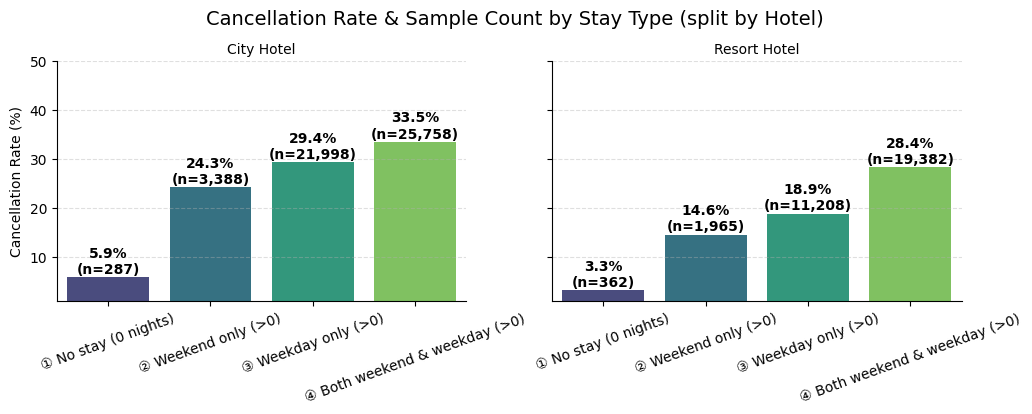

In [ ]:
order = [
    "① No stay (0 nights)",
    "② Weekend only (>0)",
    "③ Weekday only (>0)",
    "④ Both weekend & weekday (>0)"
]

# 1️⃣ 그룹별 요약 (hotel × stay_group)
summary = (
    hotel.groupby(["hotel", "stay_group"])["is_canceled"]
         .agg(Count="count", CancelRate="mean")
         .assign(**{"Cancellation Rate (%)": lambda df: (df["CancelRate"] * 100).round(2)})
         .drop(columns="CancelRate")
         .reset_index()
)

# 2️⃣ stay_group 순서 고정
summary["stay_group"] = pd.Categorical(summary["stay_group"], categories=order, ordered=True)
summary = summary.sort_values(["hotel", "stay_group"])

# 3️⃣ 시각화 (호텔별 2개의 그래프)
g = sns.catplot(
    data=summary,
    kind="bar",
    x="stay_group",
    y="Cancellation Rate (%)",
    hue="stay_group",
    col="hotel",
    order=order,
    palette="viridis",
    legend=False,
    sharey=True,
    height=4,
    aspect=1.3
)

# 4️⃣ 각 facet별 막대 위 라벨 표시
for ax, (hotel_name, sub) in zip(g.axes.flat, summary.groupby("hotel")):
    sub = sub.set_index("stay_group").reindex(order).reset_index()
    for patch, (_, row) in zip(ax.patches, sub.iterrows()):
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        ax.text(
            x, y + 0.2,
            f"{row['Cancellation Rate (%)']:.1f}%\n(n={int(row['Count']):,})",
            ha="center", va="bottom",
            fontsize=10, fontweight="bold", color="black"
        )

# 5️⃣ 축, 제목 등 정리
g.set_axis_labels("", "Cancellation Rate (%)")
g.set_titles("{col_name}")

# y축 범위 & 격자
for ax in g.axes.flat:
    ax.set_ylim(1, 50)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.tick_params(axis="x", rotation=20)

# 여백 조정 & 제목
plt.subplots_adjust(top=0.85, bottom=0.25)
g.fig.suptitle("Cancellation Rate & Sample Count by Stay Type (split by Hotel)", fontsize=14)
plt.show()


0박 고객들의 취소율이 가장 낮은 것은 동일하네요.

그리고 전체적으로 City Hotel의 취소율이 더 높았군요!

평일 / 주말 여부와는 별개로, 시티호텔의 취소율이 더 높은 이유를 분석해보면 좋겠습니다.

*   **개인/협업** 예약 << **단체** 예약
*   **직접** 예약 << **대리인** 예약
* **아이 有** < **아이 無**
* **0박** << 주말에만 1박 이상 < 평일 1박 이상
* **Resort Hotel** << **City Hotel**

### *가설 4. 예약변경 횟수가 많을수록 취소율은 낮을 것이다 ?*

관련 컬럼 : "booking_changes"

데이터 결과값별 취소율을 확인해본 후, 어떻게 그룹을 나눌지 정해볼게요.



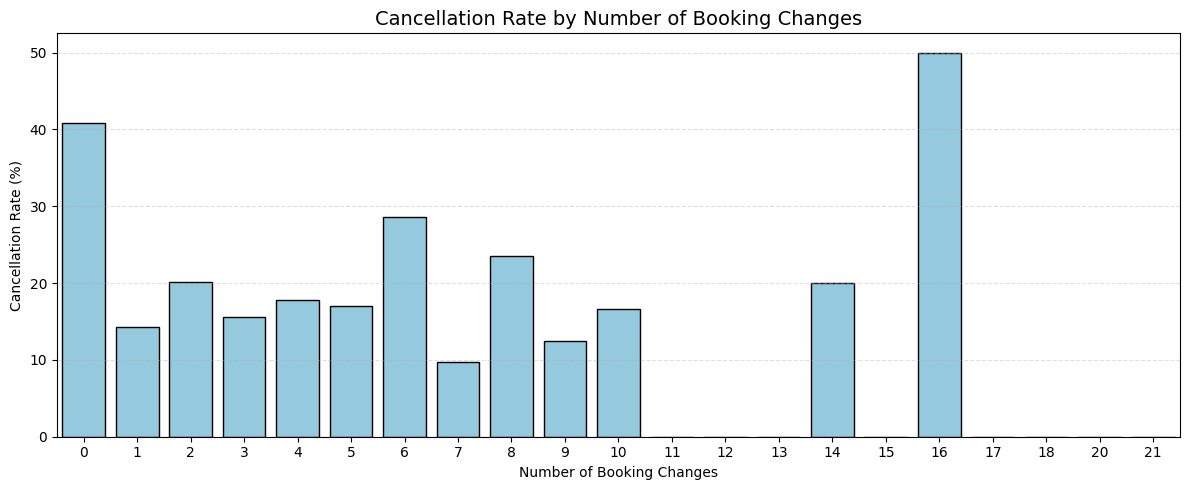

In [ ]:
# 1️⃣ booking_changes 값별 취소율(%) 계산
cancel_by_changes = (
    hotel.groupby("booking_changes")["is_canceled"]
    .mean() * 100
).reset_index()
cancel_by_changes.columns = ["booking_changes", "Cancellation Rate (%)"]

# 2️⃣ 막대그래프 시각화
plt.figure(figsize=(12,5))
ax = sns.barplot(
    data=cancel_by_changes,
    x="booking_changes",
    y="Cancellation Rate (%)",
    color="skyblue",
    edgecolor="black"
)

# 3️⃣ 그래프 꾸미기
plt.title("Cancellation Rate by Number of Booking Changes", fontsize=14)
plt.xlabel("Number of Booking Changes")
plt.ylabel("Cancellation Rate (%)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


위 그래프를 보니, 아래와 같이 4개 그룹으로 나눠서 취소율을 살펴봐야겠습니다.

0번 / 1번부터 5번 / 6번부터 10번 / 11번 이상


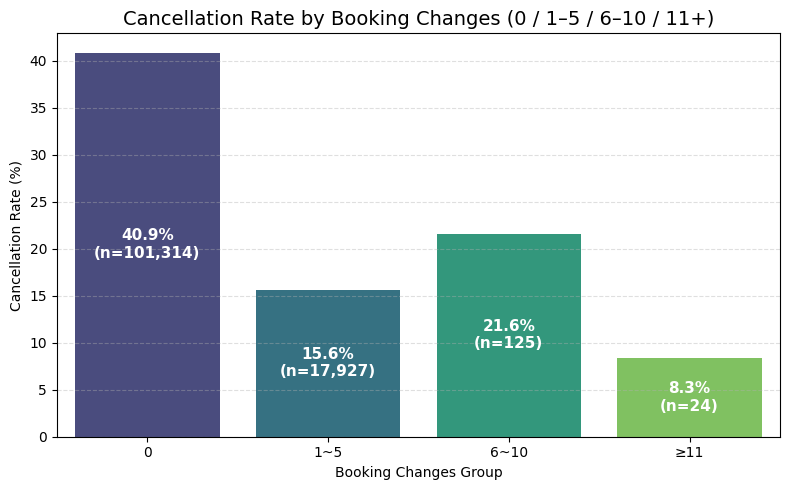

In [ ]:
# 1️⃣ booking_changes 4개 그룹으로 나누기
bins = [-np.inf, 0.5, 5.5, 10.5, np.inf]
labels = ["0", "1~5", "6~10", "≥11"]
hotel["booking_changes_grp"] = pd.cut(hotel["booking_changes"], bins=bins, labels=labels, right=True)

# 2️⃣ 각 그룹별 취소율(%)과 데이터 개수 집계
summary = (
    hotel.groupby("booking_changes_grp", observed=False)["is_canceled"]
    .agg(Count="count", CancelRate="mean")
    .assign(**{"Cancellation Rate (%)": lambda s: (s["CancelRate"] * 100).round(2)})
    .drop(columns="CancelRate")
    .reset_index()
)

# 3️⃣ 표시 순서 고정
order = ["0", "1~5", "6~10", "≥11"]
summary = summary.set_index("booking_changes_grp").reindex(order).reset_index()

# 4️⃣ 시각화 (막대그래프)
plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=summary,
    x="booking_changes_grp",
    y="Cancellation Rate (%)",
    order=order,
    hue="booking_changes_grp",
    palette="viridis",
    legend=False
)

# 5️⃣ 막대 중앙에 취소율 + 샘플수(n) 표시
for patch, (_, row) in zip(ax.patches, summary.iterrows()):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height() / 2
    ax.text(
        x, y,
        f"{row['Cancellation Rate (%)']:.1f}%\n(n={int(row['Count']):,})",
        ha="center", va="center", color="white", fontsize=11, fontweight="bold"
    )

# 6️⃣ 그래프 꾸미기
plt.title("Cancellation Rate by Booking Changes (0 / 1–5 / 6–10 / 11+)", fontsize=14)
plt.xlabel("Booking Changes Group")
plt.ylabel("Cancellation Rate (%)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


가설이 맞았군요!

예약 변경을 한번도 안한 그룹의 취소율이 월등히 높고, 예약변경 횟수가 많은 그룹의 취소율이 가장 낮습니다.

(14번, 16번 막대그래프는 데이터 개수가 각 5개, 2개이기에 유의미하다고 보기엔 어렵겠죠?)

예약 변경을 할 만큼의 의지가 있다면, 취소하지 않을 확률이 높겠다고 생각해서 세운 가설인데

역시나 11번 이상 예약변경한 사람들의 취소율이 낮습니다.

그래도 11번 이상 예약을 변경하는건... 너무한 것 같네요. 호텔 화이팅

*   **개인/협업** 예약 << **단체** 예약
*   **직접** 예약 << **대리인** 예약
* **아이 有** < **아이 無**
* **0박** << 주말에만 1박 이상 < 평일 1박 이상
* **Resort Hotel** << **City Hotel**
* **예약변경횟수 多** << **예약변경횟수 0번**





### *가설 5. 할당된 객실 유형(A~C타입)에 따라 취소율이 과연 다를까?*

관련 컬럼 : "reserved_room_type"

모든 타입의 취소율을 한번에 보겠습니다.

In [ ]:
hotel.value_counts("reserved_room_type")

,count
reserved_room_type,
A,85994
D,19201
E,6535
F,2897
G,2094
B,1118
C,932
H,601
P,12


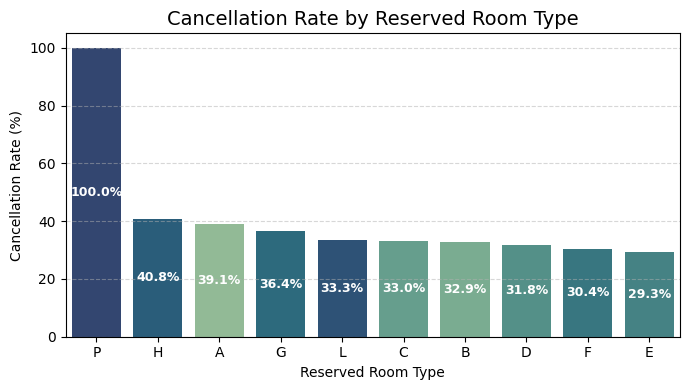

In [ ]:
# 1️⃣ reserved_room_type별 취소율 계산 (%)
room_cancel_rate = (
    hotel.groupby("reserved_room_type")["is_canceled"]
    .mean() * 100
).round(2)

# 2️⃣ 시각화를 위한 데이터프레임 형태로 변환
room_cancel_df = room_cancel_rate.reset_index()
room_cancel_df.columns = ["Reserved Room Type", "Cancellation Rate (%)"]

# 3️⃣ 막대그래프 시각화
plt.figure(figsize=(7,4))
ax = sns.barplot(
    data=room_cancel_df,
    x="Reserved Room Type",
    y="Cancellation Rate (%)",
    palette="crest",
    order=room_cancel_df.sort_values("Cancellation Rate (%)", ascending=False)["Reserved Room Type"],
    hue="Reserved Room Type",
    legend=False
)

# 4️⃣ 각 막대 가운데에 수치 표시
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.1f%%",
        label_type="center",
        fontsize=9,
        fontweight="bold",
        color="white"
    )

# 5️⃣ 그래프 꾸미기
plt.title("Cancellation Rate by Reserved Room Type", fontsize=14)
plt.xlabel("Reserved Room Type")
plt.ylabel("Cancellation Rate (%)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


대부분의 룸타입은 취소율에 큰 차이가 없으나, P는 취소율이 100% 네요!

물론 데이터 수가 12개 밖에 안되지만, 100%라니...

호텔의 관리인이라면, P타입 룸에 고객들이 기피할 어떤 문제점이 있는 것인지 확인해 볼 필요가 있어 보입니다.

*   **개인/협업** 예약 << **단체** 예약
*   **직접** 예약 << **대리인** 예약
* **아이 有** < **아이 無**
* **0박** << 주말에만 1박 이상 < 평일 1박 이상
* **Resort Hotel** << **City Hotel**
* **예약변경횟수 多** << **예약변경횟수 0번**
*  다른 Type << **P Type**

### *가설 6. 고객 요청과 다른 타입의 객실로 배정된 경우, 취소율이 높을 것이다 ?*

관련 컬럼 : "assigned_room_type"

이 컬럼에는 호텔 운영상의 이유(ex. 초과 예약 등) 또는 고객 요청으로 인해 예약한 객실과 다른 객실 유형이 배정되는 경우를 담고 있습니다.

일단 모든 타입별 취소율을 보겠습니다.

In [ ]:
hotel.value_counts("assigned_room_type")

,count
assigned_room_type,
A,74053
D,25322
E,7806
F,3751
G,2553
C,2375
B,2163
H,712
I,363


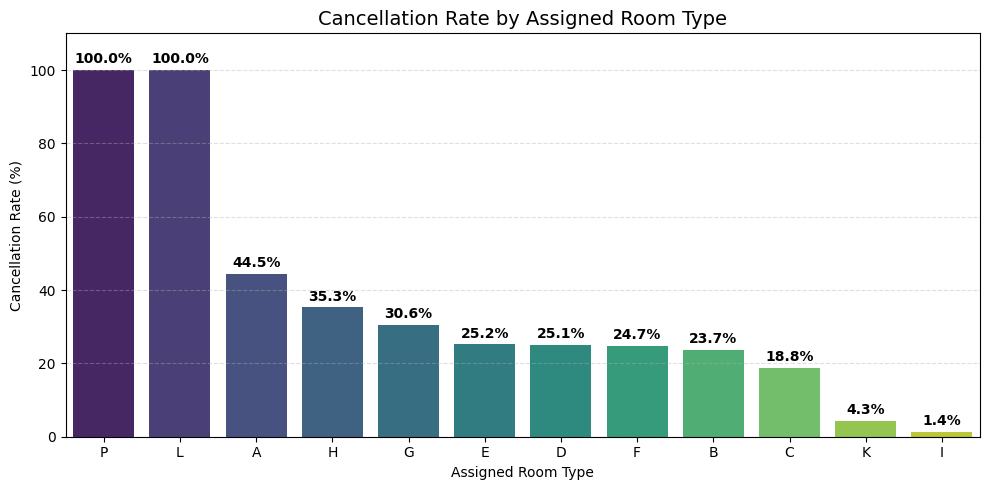

In [ ]:
# 1️⃣ 객실유형별 취소율(%) 계산
room_cancel = (
    hotel.groupby("assigned_room_type")["is_canceled"]
    .mean() * 100
).reset_index()
room_cancel.columns = ["Assigned Room Type", "Cancellation Rate (%)"]

# 2️⃣ 취소율 기준 내림차순 정렬
room_cancel = room_cancel.sort_values("Cancellation Rate (%)", ascending=False)

# 3️⃣ 시각화 (막대그래프)
plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=room_cancel,
    x="Assigned Room Type",
    y="Cancellation Rate (%)",
    palette="viridis",
    hue="Assigned Room Type",
    legend=False
)

# 4️⃣ 각 막대 중앙 또는 위쪽에 수치 표시
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(
        x, y + 1,
        f"{y:.1f}%",
        ha="center", va="bottom",
        color="black", fontsize=10, fontweight="bold"
    )

# 5️⃣ 그래프 꾸미기
plt.title("Cancellation Rate by Assigned Room Type", fontsize=14)
plt.xlabel("Assigned Room Type")
plt.ylabel("Cancellation Rate (%)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.ylim(0, room_cancel["Cancellation Rate (%)"].max() + 10)
plt.tight_layout()
plt.show()


어머나..... P타입 룸은 정말 문제가 있나보네요. 여기서도 취소율이 100% 입니다.

L타입은 데이터 개수가 1개이고, 가설 5번에서는 유의미한 취소율을 보이지 않았기에 고려하지 않아도 될 것 같습니다.

그나저나 K,I타입 룸은 무얼까요? 가설 5번에서는 볼 수 없던 타입인데요 이거... 엄청 좋은 룸인가 봅니다.

호텔 운영상의 이유로 어쩔 수 없이 내주는 그런.. 비싸고 좋은 룸이니까 취소율이 저렇게 낮은게 아닐런지요(?)

Anyway, 그 외 타입들은 가설 5번과 비교를 해봐야겠습니다.

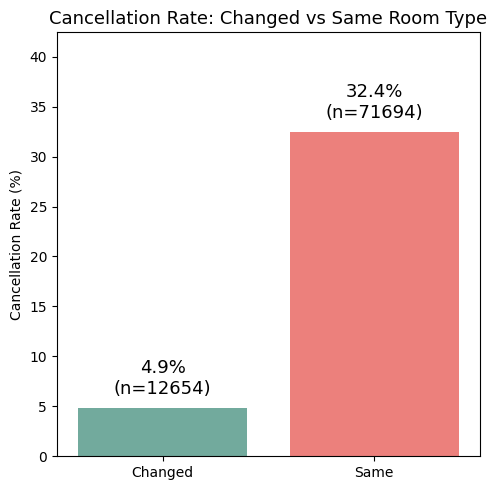

In [ ]:
# 1️⃣ 예약/배정 동일 여부 컬럼 추가
hotel["room_changed"] = hotel.apply(
    lambda row: "Changed" if row["reserved_room_type"] != row["assigned_room_type"] else "Same",
    axis=1
)

# 2️⃣ 그룹별 취소율 + 샘플수 계산
cancel_rate_simple = (
    hotel.groupby("room_changed")
    .agg(
        cancellation_rate=("is_canceled", "mean"),
        count=("is_canceled", "size")
    )
    .reset_index()
)

# 퍼센트로 변환
cancel_rate_simple["cancellation_rate"] = (cancel_rate_simple["cancellation_rate"] * 100).round(2)

# 3️⃣ 시각화
plt.figure(figsize=(5,5))
ax = sns.barplot(
    data=cancel_rate_simple,
    x="room_changed",
    y="cancellation_rate",
    hue="room_changed",
    palette=["#69b3a2", "#ff6f69"],
    legend=False
)

# 4️⃣ 각 막대 위에 취소율 + 샘플수 표시
for i, row in cancel_rate_simple.iterrows():
    ax.text(
        i,
        row["cancellation_rate"] + 1,  # 막대 위쪽에 살짝 띄워 표시
        f'{row["cancellation_rate"]:.1f}%\n(n={row["count"]})',
        ha='center',
        va='bottom',
        fontsize=13,
        color='black'
    )

plt.title("Cancellation Rate: Changed vs Same Room Type", fontsize=13)
plt.ylabel("Cancellation Rate (%)")
plt.xlabel("")
plt.ylim(0, cancel_rate_simple["cancellation_rate"].max() + 10)
plt.tight_layout()
plt.show()


오히려 임의배정된 방들의 취소율이 훨씬 낮네요!

어느 방에 배정되어도 신경쓰지 않는 Cool한 소수의 고객들이기 때문일지...

아무튼 이 자료만으로 취소율 개선을 위해 활용하기에는 어려워 보이네요.

가설 6번이 틀린 것으로 마무리하고 넘어가겠습니다!


*   **개인/협업** 예약 << **단체** 예약
*   **직접** 예약 << **대리인** 예약
* **아이 有** < **아이 無**
* **0박** << 주말에만 1박 이상 < 평일 1박 이상
* **Resort Hotel** << **City Hotel**
* **예약변경횟수 多** << **예약변경횟수 0번**
*  다른 Type << **P Type**
*  임의 배정된 룸의 취소율이 오히려 더 낮았다.

## 4. 유의미한 결론
위 가설들을 검증하며 유의미하게 취소율이 높은 경우를 추려보겠습니다.

*   **단체 예약**의 취소율이 확실히 높다!
*   **대리인 예약**의 취소율이 확실히 높다!
* **City Hotel**의 취소율이 높다!
* **예약변경을 한번도 안한 사람들**의 취소율이 높다!
*  **P Type 룸**은 다 취소한다...!


아이 유무에 따른 차이는 그리 크지 않아서 빼겠습니다.

또한 **0박**의 취소율이 유의미하게 낮은 것도 확인되었죠!

이를 토대로 취소율 개선 아이디어를 낼 수 있을 것 같습니다.


## 5. 예약 취소율 개선 아이디어

취소율을 개선하는 방안으로 크게 2가지를 보겠습니다.

### 5-1. 취소율이 높은 이유를 찾아 해결하기

* **단체, 대리인 예약**의 취소율이 높다!
+ + 단체, 대리인 예약자들의 취소율을 낮추기 위해 패널티를 강화하는 것이 좋을 것 같습니다. 중도 취소시 부과되는 수수료를 높이는 것이 어떨까요?

* **City Hotel**의 취소율이 높다!
+ + Resort Hotel과 비교하여 City Hotel의 개선점이 무엇인지 파악 후, 해결할 수 있는 부분은 해결하고 해결할 수 없는 것이라면 신규 고객층을 노리는 등 새로운 방법을 모색해보는 것이 좋을 것 같습니다.

* **예약변경을 한번도 안한 사람들**의 취소율이 높다!
+ + 고객의 예약변경 횟수는 조절이 불가능하지만, 예약변경 절차를 보다 쉽고 간편하게 만들면 예약변경을 유도하여 취소율이 낮아지게 할 수 있지 않을까요?

*  **P Type 룸**은 다 취소한다...!
+ + P타입 룸의 문제점이 무엇인지 고객과 직원들을 대상으로 설문조사를 시행한 후, 원인이 파악되면 해결해야겠습니다.


### 5-2. 취소율이 낮은 그룹을 대상으로 마케팅하기

* **개인 예약** 고객 대상 마케팅
+ + 개인과 단체의 구분을 어떤 기준으로 하는지 먼저 확인이 필요할 것 같습니다. 개인 고객의 취소율이 확실히 적기 때문에, 이후에는 마케팅 전략을 꼭 수립하면 좋겠네요!

* **협력업체 예약** 고객 확보
+ + 협력업체를 늘리는 것도 좋은 방법이겠습니다. 늘리는 것이 어렵다면, 기존 협력업체들과의 활발한 활동은 꼭 사수해야겠죠!

* **직접 예약** 고객 대상 마케팅
+ + 자동차보험 다이렉트처럼, 호텔 홈페이지나 어플을 통해 직접 예약하는 경우 할인율을 더 높이거나 쿠폰을 주면 좋을 것 같습니다.

* **0박 예약** 고객 대상 마케팅
+ + 사실 0박 고객의 수는 적습니다. 다른 마케팅에 힘을 실는 것이 좋겠네요!

### 5-3. 아이디어 정리
1) **중도 취소시 수수료 높이기**
2) **City Hotel의 개선점 파악 및 대비**
3) **예약 변경 절차 더욱 간편화**
4) **P타입 룸 관련 설문조사 후 원인 해결**
5) **개인 고객을 대상으로 한 마케팅 전략 수립**
6) **협력업체 늘리기**
7) **Direct 예약시 쿠폰 or 높은 할인율 적용**